In [1]:

"""
   Zonally reentrant channel with an unstable zonal jet.
   Writes data to file in netcdf or raw, own format.
   Jax compatible, but in multihost environment 
   only for raw snaphot output.
"""

import pyOM3 as OM
from pyOM3.pe_simple.snapshot  import snap_raw,snap_nc4
from pyOM3.density             import get_rho
jnp = OM.np

# set some parameter
Lx, Ly, Lz, f0, N0 = 250e3, 250e3, 500., 1e-4,50e-4 
n_pes_x, n_pes_y = 1, 1

fac = 1  # scale factor
nx,ny,nz = fac*25, fac*25, fac*10
dx,dy,dz,dt = Lx/nx,Ly/ny,Lz/nz,600./fac

# dictionary with model parameter for intialisation
pa={ 'nx':nx, 'ny':ny, 'nz':nz, 'dx':dx, 'dy':dy, 'dz':dz, 'dt':dt, 
     'max_iterations':5000, 'epsilon':1e-12,'snapint':dt,'Ahbi': 0.2e10/fac**3,  
     'eq_of_state':0,'implicit_free_surface':False,'periodic_in_x':True,'periodic_in_y':False,
     'explicit_free_surface':False, 'sub_cycling':10}


# define initial conditions, Jax compatible
class jax_model(snap_nc4): # inheret here from snap_raw instead for raw output

      def my_init(self):  
          """
          set some initial conditions
          """
          x_full = jnp.arange(nx,dtype=jnp.float64)*dx +dx/2.
          y_full = jnp.arange(ny,dtype=jnp.float64)*dy +dy/2.
          z_full = jnp.arange(nz,dtype=jnp.float64)*dz +dz/2

          self.u , self.v, self.temp = self.unpad(self.u), self.unpad(self.v), self.unpad(self.temp)
          for shard in self.u.addressable_shards:                                                              
              s = shard.index
              z,y,x = z_full[s[0]]  , y_full[s[1]] , x_full[s[2]]                  
              Z,Y,X = jnp.meshgrid(z,y,x, indexing='ij')
              u = .2*( -jnp.exp( -( (Y-Ly/2) )**2/10e3**2 )*jnp.cos(Z/Lz*jnp.pi) + \
                       0.05*jnp.sin(X/500e3*10*jnp.pi)*jnp.sin(Y/Ly*2*jnp.pi)*jnp.cos(Z/Lz*jnp.pi) )   
              v = jnp.zeros_like(u)             
              uz = -.2*(-jnp.exp( -( (y_full-Ly/2) )**2/10e3**2 ) )
              b = jnp.cumsum(-dy*uz*f0)
              b = b[(None,s[1],None)]*jnp.sin(Z/Lz*jnp.pi)/Lz*jnp.pi + N0**2*Z   
              self.u = OM.modify_array(self.u, s, u, out_sharding = self.sharding_3D)    
              self.v = OM.modify_array(self.v, s, v, out_sharding = self.sharding_3D)
              self.temp = OM.modify_array(self.temp, s, b, out_sharding = self.sharding_3D)     
              
          self.u , self.v, self.temp = self.pad(self.u), self.pad(self.v), self.pad(self.temp)    
          self.u, self.v  = self.apply_bc(  self.u) , self.apply_bc(  self.v)
          self.w    = self.vertical_velocity(self.u,self.v,self.w,self.maskW) 
          self.temp = self.apply_bc(  self.temp) 
          self.rho  = get_rho(self.salt,self.temp,self.p0,self.eq_of_state)
          return    


class mpi_model(snap_nc4):
    
      def my_init(self,pa):
          x_full = jnp.arange(nx,dtype=jnp.float64)*dx +dx/2.
          y_full = jnp.arange(ny,dtype=jnp.float64)*dy +dy/2.
          z_full = jnp.arange(nz,dtype=jnp.float64)*dz +dz/2
          x,y,z = x_full[slice(self.xs_pe-1,self.xe_pe)] , y_full[slice(self.ys_pe-1,self.ye_pe)], z_full
          
          Z,Y,X = jnp.meshgrid(z,y,x, indexing='ij')
          u = .2*( -jnp.exp( -( (Y-Ly/2) )**2/10e3**2 )*jnp.cos(Z/Lz*jnp.pi) + \
                       0.05*jnp.sin(X/500e3*10*jnp.pi)*jnp.sin(Y/Ly*2*jnp.pi)*jnp.cos(Z/Lz*jnp.pi) )   
          v = jnp.zeros_like(u)             
          uz = -.2*(-jnp.exp( -( (y_full-Ly/2) )**2/10e3**2 ) )
          
          b = jnp.cumsum(-dy*uz*f0)
          b = b[None,slice(self.ys_pe-1,self.ye_pe),None]*jnp.sin(Z/Lz*jnp.pi)/Lz*jnp.pi + N0**2*Z   

          sl = slice(self.halo,-self.halo)
          self.u    = self.apply_bc( OM.modify_array(self.u ,(sl,sl,sl), u) )
          self.v    = self.apply_bc( OM.modify_array(self.v ,(sl,sl,sl), v) )
          self.w    = self.vertical_velocity(self.u,self.v,self.w,self.maskW) 
          self.temp = self.apply_bc( OM.modify_array(self.temp ,(sl,sl,sl), b) )
          self.rho  = get_rho(self.salt,self.temp,self.p0,self.eq_of_state)          
          return    

M = jax_model(pa, n_pes_x = n_pes_x, n_pes_y = n_pes_y)
#M = mpi_model(pa, n_pes_x = n_pes_x, n_pes_y = n_pes_y)
M.set_coriolis(f0)
M.set_topography()
M.prepare_for_run( snap_file_name = 'snap.cdf',show_each_time_step = False)
M.my_init()
M.snapint = 86400.
M.loop(max_steps=int(30*86400/dt)+1)  


found Jax but could not initialise multihost Jax environment
found  1  processes and  1  devices 
Device list : [CpuDevice(id=0)]
found no keyword out_sharding in .at[].set())
t=  0.000 s n= 0 itts= 148 error=5.54e-13
 --> writing to file  snap.cdf
 total itts in solver  148
t= 86400.000 s n= 216 itts= 152 error=8.46e-13
 --> writing to file  snap.cdf
 total itts in solver  32884
t=      2.0 d n= 432 itts= 151 error=8.20e-13
 --> writing to file  snap.cdf
 total itts in solver  32637
t=      3.0 d n= 648 itts= 151 error=9.66e-13
 --> writing to file  snap.cdf
 total itts in solver  32549


KeyboardInterrupt: 

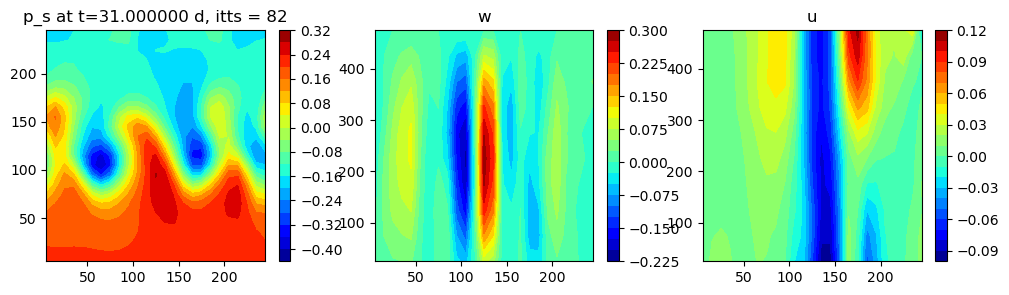

In [7]:
import pyOM3 as OM
from pyOM3.pe_simple.model   import model
from IPython import display
import pylab as plt

jnp = OM.np
Lx,Ly,Lz,f0,N0 = 250e3,250e3,500., 1e-4,50e-4 

fac = 1 
nx,ny,nz = fac*25, fac*25, fac*10
dx,dy,dz,dt = Lx/nx,Ly/ny,Lz/nz,600./fac

# dictionary with model parameter for intialisation
pa={ 'nx':nx, 'ny':ny, 'nz':nz, 'dx':dx, 'dy':dy, 'dz':dz, 'dt':dt, 
     'max_iterations':5000, 'epsilon':1e-12,'snapint':dt,'Ahbi': 0.2e10/fac**3,  
     'eq_of_state':0,'implicit_free_surface':False,'periodic_in_x':True,'periodic_in_y':False,
     'explicit_free_surface':False, 'sub_cycling':10}
     
  
# initial conditions
x = jnp.arange(nx,dtype=jnp.float64)*dx +dx/2.
y = jnp.arange(ny,dtype=jnp.float64)*dy +dy/2.
z = jnp.arange(nz,dtype=jnp.float64)*dz +dz/2
Z,Y,X = jnp.meshgrid(z,y,x, indexing='ij')
u = .2*(-jnp.exp( -( (Y-Ly/2) )**2/10e3**2 ) )*jnp.cos(Z/Lz*jnp.pi)
v = 0.01*jnp.sin(X/Lx*5*jnp.pi)*jnp.cos(Z/Lz*jnp.pi)*jnp.sin(Y/Ly*jnp.pi)
# 0 = -p_z + b, 0 = - p_y - fu,  b_y = -fu_z,   B = N0^2*z
uz = -.2*(-jnp.exp( -( (Y-Ly/2) )**2/10e3**2 ) )*jnp.sin(Z/Lz*jnp.pi)/Lz*jnp.pi
buoyancy = jnp.cumsum(-dy*uz*f0,axis=1) + N0**2*Z
#fu = - p_y
p_s = jnp.cumsum(-dy*u[-1,:,:]*f0,axis=0)  


class my_model(model):
    
      def prepare_for_run(self):
          super().prepare_for_run()
          self.fig = plt.figure(figsize=(4*3,3))
          return
      
      def diagnose(self,n,tau):  
          if n==0 or jnp.mod(n,int(self.snapint/self.dt))==0.: # writing to file
             t =  n*self.dt
             self.fig.clf()               
             ax = self.fig.add_subplot(1,3,1) 
             co = ax.contourf(x/1e3,y/1e3,self.p_s[tau,1:-1,1:-1],20,cmap='jet') 
             ax.set_title("p_s at t=%f d, itts = %i"%(t/86400,self.congr_itts) )   
             self.fig.colorbar(co) 
             ax = self.fig.add_subplot(1,3,2)   
             co = ax.contourf(y/1e3,z,self.w[1:-1,1:-1,1]*1e3,20,cmap='jet') 
             ax.set_title("w" )   
             self.fig.colorbar(co) 
             ax = self.fig.add_subplot(1,3,3)   
             co = ax.contourf(y/1e3,z,self.u[1:-1,1:-1,1],20,cmap='jet') 
             ax.set_title("u" )   
             self.fig.colorbar(co)  
             display.display(self.fig)
             display.clear_output(wait=True) 

                         
pa['snapint'] = 86400.
M = my_model(pa)
M.set_coriolis(f0)
M.set_topography()
M.prepare_for_run()
M.set_initial_conditions(u,v,buoyancy,buoyancy*0,p_s)
M.loop(max_steps=int(86400*25/M.dt))  